# **Extract Object Points & Image Points**

---



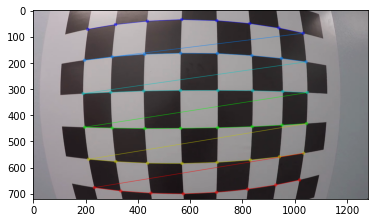

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*8,3), np.float32)
objp[:,:2] = np.mgrid[0:8, 0:6].T.reshape(-1,2)


# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
fname = 'calibration_test.png'
img1 = cv2.imread(fname)

# Converting an image, imported by cv2 or the glob API, to grayscale:
gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

# Finding chessboard corners (for an 8x6 board):
ret, corners = cv2.findChessboardCorners(gray, (8, 6), None)

# If found, add object points, image points & draw corners
if ret == True:
  objpoints.append(objp)
  imgpoints.append(corners)
  # Drawing detected corners on an image:
  cv2.drawChessboardCorners(img1, (8, 6), corners, ret)
  plt.imshow(img1)
  plt.savefig("FindingCorners.png")


# **Camera Calibration & Distortion Correction**

**Note:** If you are reading in an image using mpimg.imread() this will read in an RGB image and you should convert to grayscale using cv2.COLOR_RGB2GRAY, but if you are using cv2.imread() or the glob API, as happens in this video example, this will read in a BGR image and you should convert to grayscale using cv2.COLOR_BGR2GRAY. We'll learn more about color conversions later on in this lesson, but please keep this in mind as you write your own code and look at code examples.

**A note on image shape :** The shape of the image, which is passed into the calibrateCamera function, is just the height and width of the image. One way to retrieve these values is by retrieving them from the grayscale image shape array gray.shape[::-1]. This returns the image width and height in pixel values like (1280, 960).

Another way to retrieve the image shape, is to get them directly from the color image by retrieving the first two values in the color image shape array using img.shape[1::-1]. This code snippet asks for just the first two values in the shape array, and reverses them. Note that in our case we are working with a greyscale image, so we only have 2 dimensions (color images have three, height, width, and depth), so this is not necessary.

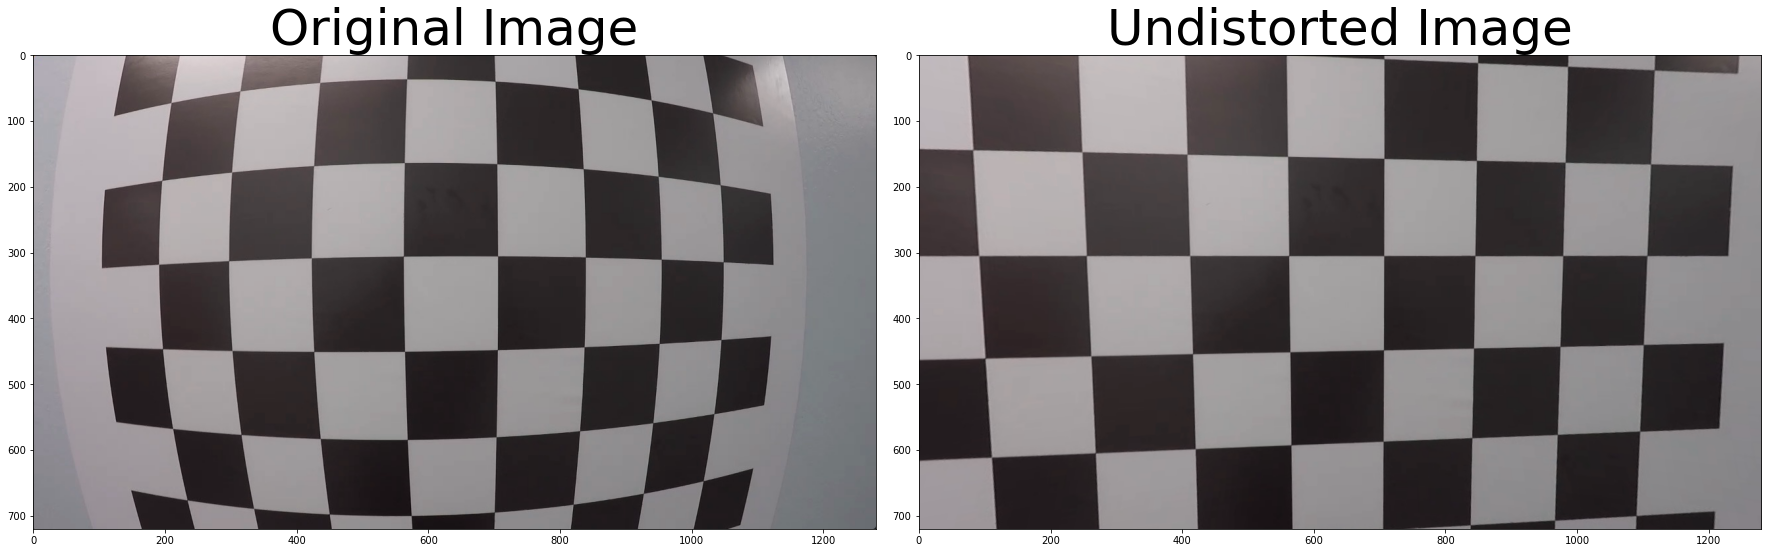

In [ ]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


'''
if you want to play with extracting object points and image points,
You can load data from  the distortion pickle file

'''

# Read in the saved objpoints and imgpoints
# dist_pickle = pickle.load( open( "wide_dist_pickle.p", "rb" ) )
# objpoints = dist_pickle["objpoints"]
# imgpoints = dist_pickle["imgpoints"]


# Read in an image
img = cv2.imread('calibration_test.png')

def cal_undistort(img, objpoints, imgpoints) :

  # Converting an image, imported by cv2 or the glob API, to grayscale:
  gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

  # Camera calibration, given object points, image points, and the shape of the grayscale image:
  ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

  #Undistorting a test image:
  undist = cv2.undistort(img, mtx, dist, None, mtx)

  return undist

undistorted = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("undistorted.png")

# **Undistort and Transform Perspective**
After i find corners, calibrate camera, undistort the image,I applied a perspective transform for Undistort image

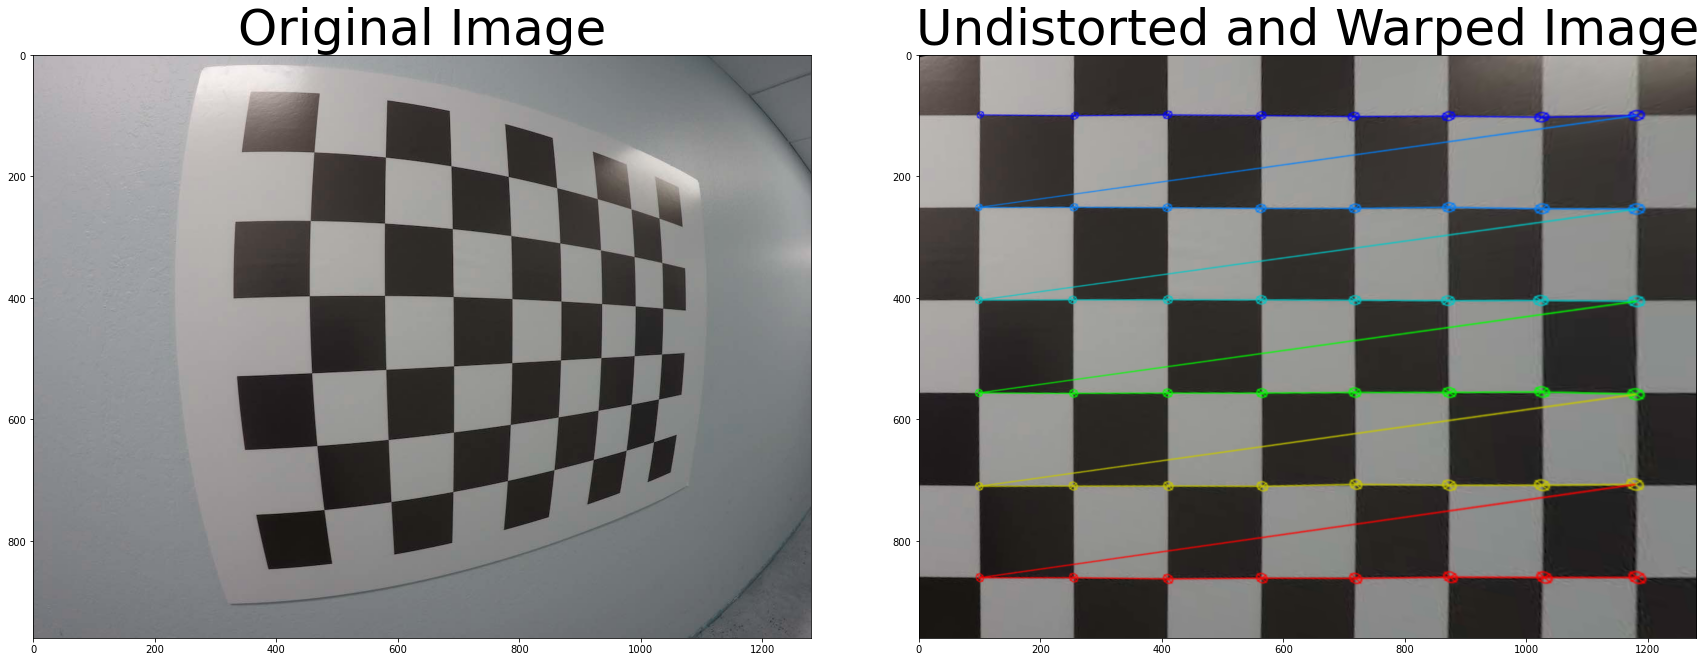

In [5]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg



'''
if you want to play with saved camera matrix and distortion coefficients,
You can load data from  the distortion pickle file

'''

# Read in the saved camera matrix and distortion coefficients

dist_pickle = pickle.load( open( "wide_dist_pickleMTX.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
imge = cv2.imread('test_image2.png')

nx = 8 # the number of inside corners in x
ny = 6 # the number of inside corners in y

def corners_unwarp(img, nx, ny, mtx, dist):
    # Undistort using mtx and dist
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert to grayscale
    gray = cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY) # Convert to grayscale
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    # If corners found: 
    if ret == True:
        # If we found corners, draw them! (just for fun)
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners
        # My choice of 100 pixels is not exact, but close enough for our purpose here
        # offset for dst points
        offset = 100 


        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M,img_size , flags=cv2.INTER_LINEAR)

    return warped, M

top_down, perspective_M = corners_unwarp(imge, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig("Undistorted_ Warped.png")